# STA365: Applied Bayesian Statistics HW 10
---
## Question 1

- A stochastic process is a collection of random variables indexed by time or space, describing systems evolving under randomness (e.g., Brownian motion, Poisson processes, Markov chains).
- A Gaussian Process (GP) is a stochastic process where any finite collection of points follows a multivariate normal distribution.
- Variatinal Inference is a method of approximating an unknown posterior distribution with another known distribution, using KL divergence as the loss function. One issue is that the KL term is intractable since we don't have access to the posterior distribution we're trying to approximate. It can be shown that minimizing the KL term is equivalent to maximizing the ELBO term.

## Question 2

In [2]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("housing.csv")

X = df["median_income"].values.reshape(-1, 1)[:100]  # Use a subset for efficiency
y = df["median_house_value"].values[:100] / 100000  # Scale target

X_scaled = (X - X.mean()) / X.std()


with pm.Model() as gp_model:
    
    #GP Prior
    mean_func = pm.gp.mean.Linear(coeffs=(0,), intercept=pm.Normal("intercept", 0, 10))
    eta = pm.HalfNormal("eta", 5)
    l = pm.Gamma("l", alpha=2, beta=1)
    cov_func = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l)
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)
    
    #Likelihood
    sigma = pm.HalfNormal("sigma", 5)
    y_obs = gp.marginal_likelihood("y_obs", X=X_scaled, y=y, noise=sigma)
    
    #Sample
    trace = pm.sample(2000, tune=1000)

/opt/conda/lib/python3.11/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, eta, l, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 511 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


Sampling: [f_pred]


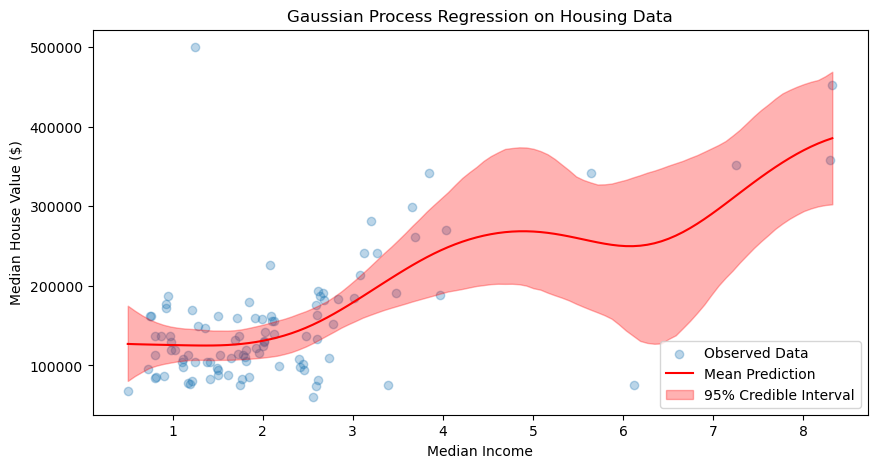

In [4]:
X_test = np.linspace(X_scaled.min(), X_scaled.max(), 100).reshape(-1, 1)
with gp_model:
    f_pred = gp.conditional("f_pred", X_test)
    pred_samples = pm.sample_posterior_predictive(trace, var_names=["f_pred"]) 

#Plot GP fit
plt.figure(figsize=(10, 5))
plt.scatter(X_scaled * X_std + X_mean, y * 100000, alpha=0.3, label="Observed Data")
plt.plot(X_test * X_std + X_mean, np.mean(pred_samples.posterior_predictive["f_pred"], axis=(0, 1)) * 100000, label="Mean Prediction", color="red")
plt.fill_between(
    X_test.flatten() * X_std + X_mean,
    np.percentile(pred_samples.posterior_predictive["f_pred"], 2.5, axis=(0, 1)) * 100000,
    np.percentile(pred_samples.posterior_predictive["f_pred"], 97.5, axis=(0, 1)) * 100000,
    color="red", alpha=0.3, label="95% Credible Interval"
)
plt.xlabel("Median Income")
plt.ylabel("Median House Value ($)")
plt.legend()
plt.title("Gaussian Process Regression on Housing Data")
plt.show()


## Question 3

In [7]:
with pm.Model() as bnn_model:
    n_hidden = 10
    
    #Priors
    w1 = pm.Normal("w1", mu=0, sigma=1, shape=(X.shape[1], n_hidden))
    b1 = pm.Normal("b1", mu=0, sigma=1, shape=(n_hidden,))
    w2 = pm.Normal("w2", mu=0, sigma=1, shape=(n_hidden, 1))
    b2 = pm.Normal("b2", mu=0, sigma=1, shape=(1,))
    
    #NN forward pass
    act_1 = pm.math.tanh(pm.math.dot(X_scaled, w1) + b1)
    act_out = pm.math.dot(act_1, w2) + b2
    
    #Likelihood
    sigma = pm.HalfNormal("sigma", 1)
    y_obs = pm.Normal("y_obs", mu=act_out.flatten(), sigma=sigma, observed=y)
    
    #VI using ADVI
    approx = pm.fit(n=50000, method=pm.ADVI())
    trace = approx.sample(1000)

Finished [100%]: Average Loss = 132.44


Sampling: [y_obs]


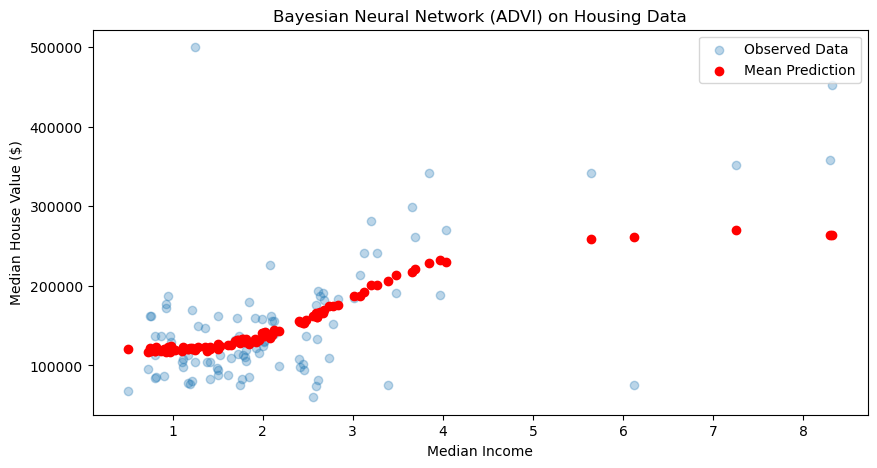

In [8]:
with bnn_model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["y_obs"])

#Plot predictions
plt.figure(figsize=(10, 5))
plt.scatter(X[:, 0], y * 100000, alpha=0.3, label="Observed Data")
plt.scatter(X[:, 0], np.mean(ppc.posterior_predictive["y_obs"], axis=(0, 1)) * 100000, label="Mean Prediction", color="red")
plt.xlabel("Median Income")
plt.ylabel("Median House Value ($)")
plt.legend()
plt.title("Bayesian Neural Network (ADVI) on Housing Data")
plt.show()